In [1]:
# necessary packages #
#cd("./Documents/Github/Multi_NNGP/RDA/projects/misalign_response/")
#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using DataFrames
using Dates
#using NearestNeighbors # Can't use KDtree in julia for posterior prediction

In [2]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [3]:
Sys.free_memory()/(2^20*1024)

26.940189361572266

In [4]:
@load "../../results/misalign_resp/misalign_resp_results.jld"

14-element Array{Symbol,1}:
 :N_sam       
 :N_burnin    
 :vec_β_sam   
 :Σ_sam       
 :Y_m_pos_qt  
 :Y_m_pos_mean
 :Y_m_pos_var 
 :Y_ord       
 :M_miss_index
 :Y_U_pos_qt  
 :Y_U_pos_mean
 :Y_U_pos_var 
 :ϕ_pick      
 :α_pick      

In [5]:
@time @load "../../data/LMC_data/misalign_res_data.jld";

┌ Warning: type OrderedCollections.OrderedDict{Symbol,Any} does not exist in workspace; reconstructing
└ @ JLD2 /home/lu/.julia/packages/JLD2/KjBIK/src/data.jl:1153


 14.431007 seconds (5.06 M allocations: 1.891 GiB, 10.92% gc time)


In [6]:
using RData
@time hold_index_set = load("../../data/rawdata/hold_index_small.RData", convert = true)

  8.445905 seconds (37.56 M allocations: 1.853 GiB, 9.37% gc time)


Dict{String,Any} with 11 entries:
  "hold_ind4"       => Int32[796395, 815927, 678460, 506073, 78700, 980165, 206…
  "hold_ind10"      => Int32[665387, 373156, 724373, 1019331, 888091, 918487, 8…
  "hold_ind2"       => Int32[518549, 906271, 597282, 651904, 872494, 353593, 32…
  "hold_ind6"       => Int32[896510, 543595, 201130, 86952, 630506, 206437, 452…
  "hold_ind5"       => Int32[811779, 351188, 843347, 549899, 712081, 81044, 972…
  "hold_ind9"       => Int32[498700, 871568, 343872, 751268, 699631, 503105, 87…
  "hold_ind7"       => Int32[914319, 272494, 251816, 456856, 273822, 586315, 96…
  "hold_ind3"       => Int32[466194, 761309, 456463, 45604, 728959, 693334, 733…
  "hold_ind1"       => Int32[548676, 452737, 124413, 436523, 856018, 666931, 25…
  "hold_ind8"       => Int32[363116, 896446, 832503, 10248, 932012, 542066, 851…
  "hold_area_indx2" => Int32[452858, 452859, 452860, 452861, 452862, 452863, 45…

In [7]:
p = 2; q = 2;

In [8]:
N

1020000

In [9]:
NM

181389

In [10]:
NR

816465

In [11]:
NU

22146

# MCMC Chain check

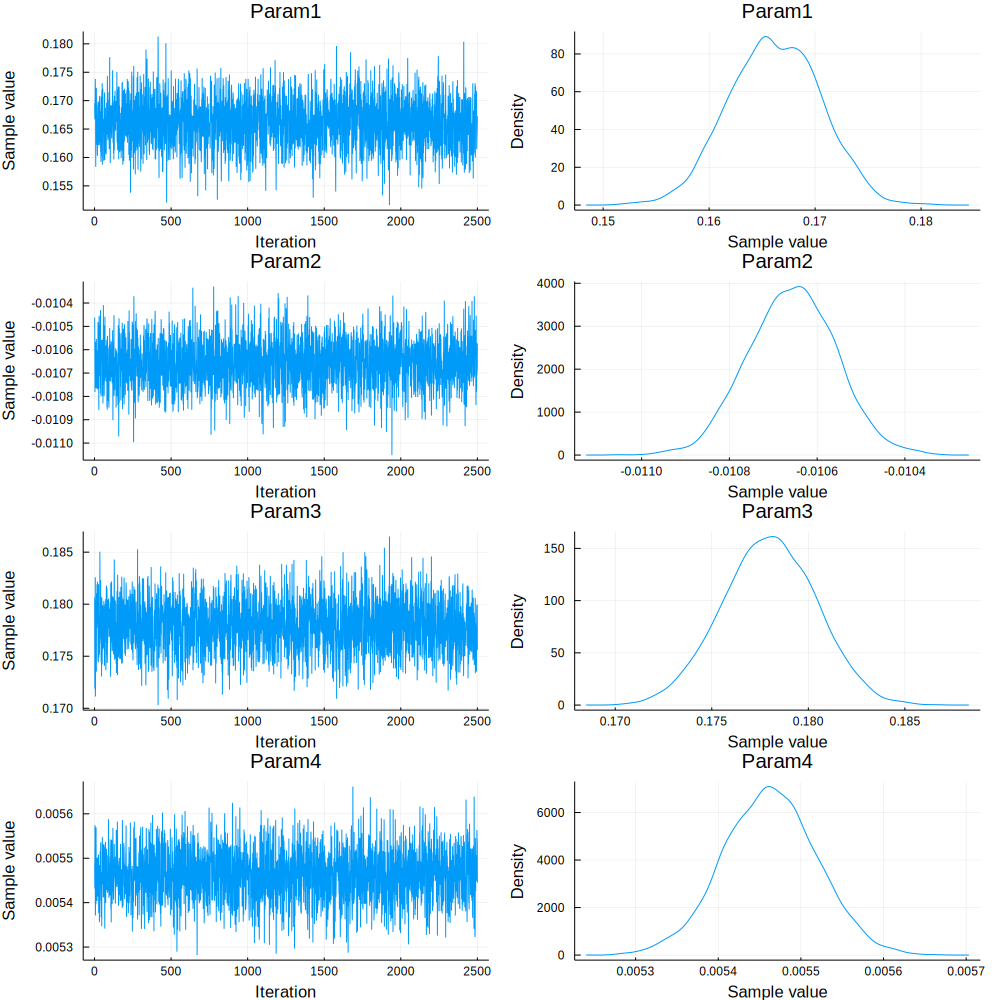

In [12]:
vec_β_pos_sam = Array{Float64, 3}(undef, N_sam - N_burnin, p * q, 1);
vec_β_pos_sam[:, :, 1] = hcat(vec_β_sam[1, :], vec_β_sam[2, :], vec_β_sam[3, :], vec_β_sam[4, :]);
vec_β_chain = Chains(vec_β_pos_sam);
pβ = plot(vec_β_chain)

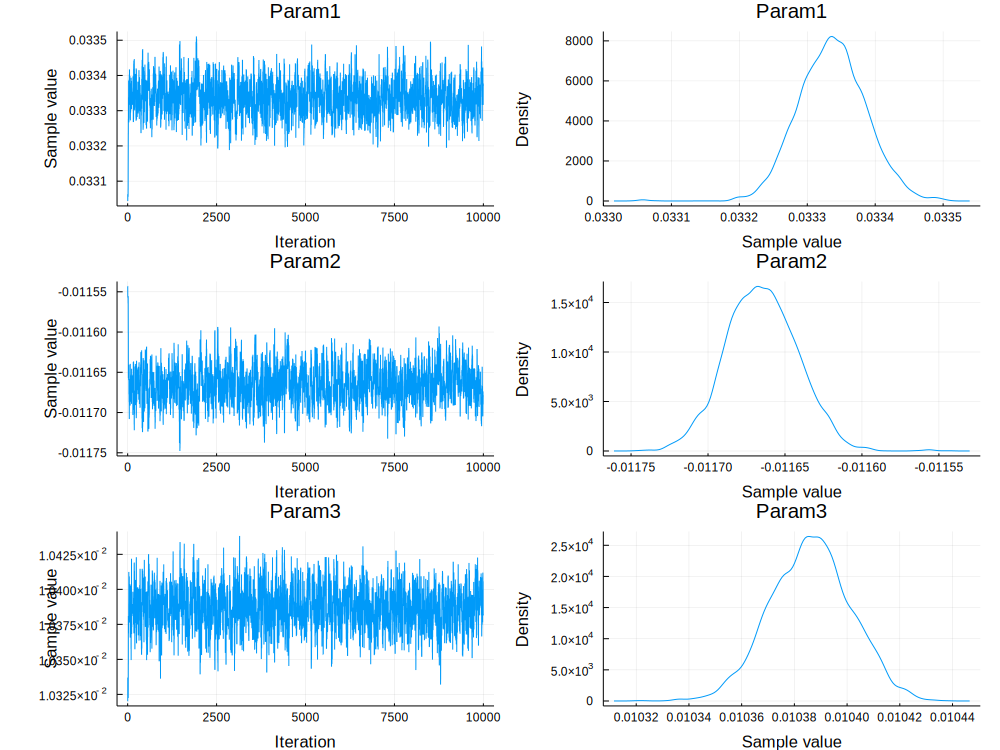

In [13]:
truncindex = 1;#Integer(trunc(N_sam / 2));
Σ_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex + 1, Integer(q * (q + 1) / 2), 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[1, 1, truncindex:N_sam], Σ_sam[2, 1, truncindex:N_sam], 
    Σ_sam[2, 2, truncindex:N_sam]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

# Posterior Inference 

In [14]:

# count the covarage of 95% CI #
count = fill(0.0, 2);l = 0;
for i in 1: NM
    for j in 1:length(M_miss_index[i])
        
        if (M_miss_index[i] == [1])
            count[1] = count[1] + ((Y_m_pos_qt[l + j, 1] < Y_ord[M[i], M_miss_index[i][j]]) && 
                        (Y_m_pos_qt[l + j, 3] > Y_ord[M[i], M_miss_index[i][j]]));
        else
            count[2] = count[2] + ((Y_m_pos_qt[l + j, 1] < Y_ord[M[i], M_miss_index[i][j]]) && 
                        (Y_m_pos_qt[l + j, 3] > Y_ord[M[i], M_miss_index[i][j]]));
        end
    end
    l = l + length(M_miss_index[i]);
end
print(count)
print(count ./ [length(M_ind[1]), length(M_ind[2])])

count2 = fill(0.0, 2);l = 0;
# count the covarage of 95% CI for predictions over U#
for j in 1:q
    for i in 1:NU
        count2[j] = count2[j] + 
        ((Y_U_pos_qt[i, j, 1] < Y_ord[U_indx[i], j]) && 
            (Y_U_pos_qt[i, j, 3] > Y_ord[U_indx[i], j]))
    end
end
print(count2)
print(count2 ./ NU)
print((count .+ count2) ./ [length(M_ind[1]) + NU, length(M_ind[2]) + NU])


[85820.0, 84843.0][0.946092, 0.935641][21557.0, 21515.0][0.973404, 0.971507][0.951451, 0.942681]

In [15]:
round.((count .+ count2) ./ [length(M_ind[1]) + NU, length(M_ind[2]) + NU], digits = 4)

2-element Array{Float64,1}:
 0.9515
 0.9427

In [16]:
round.(sum(count .+ count2) / sum([length(M_ind[1]) + NU, length(M_ind[2]) + NU]), digits = 4)

0.9471

In [17]:
# calculate root mean square predictive error #
SPE = fill(0.0, 2);
l = 0;
for i in 1: NM
    for j in 1:length(M_miss_index[i])
        if M_miss_index[i][j] == 1
            SPE[1] = SPE[1] + (Y_ord[M[i], M_miss_index[i][j]] - Y_m_pos_mean[l + j])^2;
        else 
            SPE[2] = SPE[2] + (Y_ord[M[i], M_miss_index[i][j]] - Y_m_pos_mean[l + j])^2;
        end
    end
    l = l + length(M_miss_index[i]);
end
RMSPE1 = sqrt((SPE[1] + sum((Y_ord[U_indx, 1] - Y_U_pos_mean[:, 1]).^2)) / 
    (length(M_ind[1]) + NU));
RMSPE2 = sqrt((SPE[2] + sum((Y_ord[U_indx, 2] - Y_U_pos_mean[:, 2]).^2)) / 
    (length(M_ind[2]) + NU));
RMSPE = sqrt((sum(SPE) + sum((Y_ord[U_indx, :] - Y_U_pos_mean).^2)) / 
    (length(M_ind[1]) + length(M_ind[2]) + q * NU));
round.([RMSPE1 RMSPE2 RMSPE], digits = 5)

1×3 Array{Float64,2}:
 0.03172  0.01743  0.02559

In [18]:
# MAE #
AE = fill(0.0, 2);
l = 0;
for i in 1: NM
    for j in 1:length(M_miss_index[i])
        if M_miss_index[i][j] == 1
            AE[1] = AE[1] + abs(Y_ord[M[i], 1] - Y_m_pos_mean[l + j]);
        else 
            AE[2] = AE[2] + abs(Y_ord[M[i], 2] - Y_m_pos_mean[l + j]);
        end
    end
    l = l + length(M_miss_index[i]);
end

MAE1 = (AE[1] + sum(abs.(Y_ord[U_indx, 1] - Y_U_pos_mean[:, 1]))) / 
    (length(M_ind[1]) + NU);
MAE2 = (AE[2] + sum(abs.(Y_ord[U_indx, 2] - Y_U_pos_mean[:, 2]))) / 
    (length(M_ind[2]) + NU);
MAE = (sum(AE) + sum(abs.(Y_ord[U_indx, :] - Y_U_pos_mean))) / 
    (length(M_ind[1]) + length(M_ind[2]) + q * NU);

round.([MAE1 MAE2 MAE], digits = 5)

1×3 Array{Float64,2}:
 0.0188  0.01112  0.01496

In [19]:
# CRPS #

SCRPS_M = fill(0.0, 2);
l = 0;
for i in 1:NM
    for j in 1:length(M_miss_index[i])
        if M_miss_index[i][j] == 1
            SCRPS_M[1] = SCRPS_M[1] + (sqrt(Y_m_pos_var[l + j]) * ( 1 /sqrt(π) - 
                2 * pdf(Normal(), (Y_ord[M[i], 1] - Y_m_pos_mean[l + j]) / sqrt(Y_m_pos_var[l + j])) -
                ((Y_ord[M[i], 1] - Y_m_pos_mean[l + j]) / sqrt(Y_m_pos_var[l + j])) * 
                (2 * cdf(Normal(), (Y_ord[M[i], 1] - Y_m_pos_mean[l + j]) / sqrt(Y_m_pos_var[l + j])) - 1 )));
        else 
            SCRPS_M[2] = SCRPS_M[2] + (sqrt(Y_m_pos_var[l + j]) * ( 1 /sqrt(π) - 
                2 * pdf(Normal(), (Y_ord[M[i], 2] - Y_m_pos_mean[l + j]) / sqrt(Y_m_pos_var[l + j])) -
                ((Y_ord[M[i], 2] - Y_m_pos_mean[l + j]) / sqrt(Y_m_pos_var[l + j])) * 
                (2 * cdf(Normal(), (Y_ord[M[i], 2] - Y_m_pos_mean[l + j]) / sqrt(Y_m_pos_var[l + j])) - 1 )));
        end
    end
    l = l + length(M_miss_index[i]);
end

CRPS_U = [(sqrt(Y_U_pos_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[U_indx[i], j] - Y_U_pos_mean[i, j]) / sqrt(Y_U_pos_var[i, j])) -
        ((Y_ord[U_indx[i], j] - Y_U_pos_mean[i, j]) / sqrt(Y_U_pos_var[i, j])) * 
        (2* cdf(Normal(), (Y_ord[U_indx[i], j] - Y_U_pos_mean[i, j]) / sqrt(Y_U_pos_var[i, j])) - 1 )))
        for i in 1:NU, j in 1:q];

CRPS1 = (sum(CRPS_U[:, 1]) + SCRPS_M[1]) / (length(M_ind[1]) + NU);
CRPS2 = (sum(CRPS_U[:, 2]) + SCRPS_M[2]) / (length(M_ind[2]) + NU);
CRPS = (sum(CRPS_U) + sum(SCRPS_M))/(2 * NU + length(M_ind[1]) + (length(M_ind[2])));
round.([CRPS1 CRPS2 CRPS], digits = 5)

1×3 Array{Float64,2}:
 -0.01523  -0.00875  -0.01199

In [20]:
#INT

SINT_M = fill(0.0, 2);
l = 0;
for i in 1:NM
    for j in 1:length(M_miss_index[i])
        if M_miss_index[i][j] == 1
            SINT_M[1] = SINT_M[1] + ((Y_m_pos_qt[l + j, 3] - Y_m_pos_qt[l + j, 1]) + 
                (2 / 0.05)*(Y_m_pos_qt[l + j, 1] - Y_ord[M[i], 1]) * 
                (Y_ord[M[i], 1] < Y_m_pos_qt[l + j, 1]) + 
                (2 / 0.05)*(Y_ord[M[i], 1] - Y_m_pos_qt[l + j, 3]) * 
                (Y_ord[M[i], 1] > Y_m_pos_qt[l + j, 3]));    
        else 
            SINT_M[2] = SINT_M[2] + ((Y_m_pos_qt[l + j, 3] - Y_m_pos_qt[l + j, 1]) + 
                (2 / 0.05) * (Y_m_pos_qt[l + j, 1] - Y_ord[M[i], 2]) * 
                (Y_ord[M[i], 2] < Y_m_pos_qt[l + j, 1]) + 
                (2 / 0.05) * (Y_ord[M[i], 2] - Y_m_pos_qt[l + j, 3]) * 
                (Y_ord[M[i], 2] > Y_m_pos_qt[l + j, 3]));
        end
    end
    l = l + length(M_miss_index[i]);
end

INT_U = [((Y_U_pos_qt[i, j, 3] - Y_U_pos_qt[i, j, 1]) + 
    (2 / 0.05)*(Y_U_pos_qt[i, j, 1] - Y_ord[U_indx[i], j]) * (Y_ord[U_indx[i], j] < Y_U_pos_qt[i, j, 1]) + 
    (2 / 0.05)*(Y_ord[U_indx[i], j] - Y_U_pos_qt[i, j, 3]) * (Y_ord[U_indx[i], j] > Y_U_pos_qt[i, j, 3]))
    for i in 1: NU, j in 1:q];

INT1 = (sum(INT_U[:, 1]) + SINT_M[1]) / (length(M_ind[1]) + NU);
INT2 = (sum(INT_U[:, 2]) + SINT_M[2]) / (length(M_ind[2]) + NU);
INT = (sum(INT_U) + sum(SINT_M))/(2 * NU + length(M_ind[1]) + (length(M_ind[2])));

round.([INT1 INT2 INT], digits = 5)

1×3 Array{Float64,2}:
 0.1909  0.10172  0.14631

In [21]:
N_burnin
summary_table = Array{Float64, 2}(undef, 10, 5);
summary_table[1, :] = vcat(0, mean(vec_β_sam[1, :]),
    quantile(vec_β_sam[1, :], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(0, mean(vec_β_sam[3, :]),
    quantile(vec_β_sam[3, :], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(0, mean(vec_β_sam[2, :]),
    quantile(vec_β_sam[2, :], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(0, mean(vec_β_sam[4, :]),
    quantile(vec_β_sam[4, :], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat(0, mean((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_burnin:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_burnin:N_sam], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat(0, mean((1 / α_pick - 1.0) .* Σ_sam[1, 2, N_burnin:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[1, 2, N_burnin:N_sam], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(0, mean((1 / α_pick - 1.0) .*Σ_sam[2, 2, N_burnin:(N_sam + 1)]),
    quantile((1 / α_pick - 1.0) .*Σ_sam[2, 2, N_burnin:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[8, :] = vcat(0,  mean(Σ_sam[1, 1, N_burnin:N_sam]),
    quantile(Σ_sam[1, 1, N_burnin:N_sam], [0.5, 0.025, 0.975]));
summary_table[9, :] = vcat(0,  mean(Σ_sam[1, 2, N_burnin:N_sam]),
    quantile(Σ_sam[1, 2, N_burnin:N_sam], [0.5, 0.025, 0.975]));
summary_table[10, :] = vcat(0,  mean(Σ_sam[2, 2, N_burnin:N_sam]),
    quantile(Σ_sam[2, 2, N_burnin:N_sam], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 5);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[1, 2]", "Σ[2, 2]", 
    "cov(ω)[1, 1]", "cov(ω)[1, 2]", "cov(ω)[2, 2]"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

|              | true |     mean |   median |     2.5% |    97.5% |
|--------------|------|----------|----------|----------|----------|
|      β[1, 1] |  0.0 |  0.16619 |  0.16614 |  0.15787 |  0.17422 |
|      β[1, 2] |  0.0 |  0.17798 |  0.17798 |  0.17326 |  0.18266 |
|      β[2, 1] |  0.0 | -0.01066 | -0.01065 | -0.01085 | -0.01047 |
|      β[2, 2] |  0.0 |  0.00546 |  0.00546 |  0.00535 |  0.00557 |
|      Σ[1, 1] |  0.0 |  0.00025 |  0.00025 |  0.00025 |  0.00025 |
|      Σ[1, 2] |  0.0 |  -9.0e-5 |  -9.0e-5 |  -9.0e-5 |  -9.0e-5 |
|      Σ[2, 2] |  0.0 |   8.0e-5 |   8.0e-5 |   8.0e-5 |   8.0e-5 |
| cov(ω)[1, 1] |  0.0 |  0.03334 |  0.03334 |  0.03325 |  0.03344 |
| cov(ω)[1, 2] |  0.0 | -0.01166 | -0.01166 | -0.01171 | -0.01162 |
| cov(ω)[2, 2] |  0.0 |  0.01039 |  0.01039 |  0.01036 |  0.01041 |


In [22]:
round((3417.695686 + 1690.704073 + 1693.711868 + 1680.139681 + 1669.059012) /60, digits = 2)

169.19

In [23]:
round((1*3600+5*60+31) / 60, digits = 2)

65.52

In [24]:
round((51*60+8) / 60, digits = 2)

51.13

In [55]:
ϕ_pick

26.414213562373096

In [56]:
α_pick

0.9926666666666666

In [62]:
169.19 + 65.52 + 51.13

285.84